In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib.pyplot import subplots, show

# Large System Ising Model
We run the simulation shown in *Rank-adaptive time integration of tree tensor networks* (Ceruti, et. al. 2022). Which is the Ising model
$$
 H = -J \sum_{k=1}^{L-1} Z_k Z_{k+1}- g \sum_{k=1}^L X_k,
$$
for $J=g=1$ and $L=10$ sites.

In [3]:
local_dim = 2
num_sites = 10
time_step_size = 0.01
final_time = 5
coupling = 1
field = 1

## Exact Solution

In [4]:
from pytreenet.operators.exact_operators import (flipped_exact_ising_hamiltonian,
                                                 exact_local_magnetisation,
                                                 exact_zero_state)
from pytreenet.time_evolution.exact_time_evolution import ExactTimeEvolution

In [5]:
exact_hamiltonian = flipped_exact_ising_hamiltonian(coupling, field, num_sites)
site_ids = [f"Qubit_{i}" for i in range(num_sites)]
exact_operators = exact_local_magnetisation(site_ids)
exact_intital_state = exact_zero_state(num_sites, local_dim)

print("Hamiltonian Shape:", exact_hamiltonian.shape)
print("Operators Shape:", exact_operators[site_ids[0]].shape)
print("Initial State Shape:", exact_intital_state.shape)

Hamiltonian Shape: (1024, 1024)
Operators Shape: (1024, 1024)
Initial State Shape: (1024,)


In [6]:
exact_evo = ExactTimeEvolution(exact_intital_state,
                               exact_hamiltonian,
                               time_step_size, final_time,
                               exact_operators)

In [7]:
exact_evo.run()

  0%|          | 0/501 [00:00<?, ?it/s]

100%|██████████| 501/501 [00:03<00:00, 136.58it/s]


## Binary TTN

In [8]:
from copy import deepcopy

from numpy import zeros, eye, max as npmax

from pytreenet.ttns import TreeTensorNetworkState
from pytreenet.core.node import Node
from pytreenet.operators.models import flipped_ising_model, local_magnetisation
from pytreenet.operators.common_operators import ket_i
from pytreenet.ttno import TreeTensorNetworkOperator
from pytreenet.operators.tensorproduct import TensorProduct
from pytreenet.time_evolution.bug import BUG, BUGConfig

In [9]:
root_id = "Root"
virtual_ids = ["1_0","2_0","2_1","2_2","3_0","3_1","3_2","3_3"]
virtual_ids = ["Virtual_" + id for id in virtual_ids]
site_ids = site_ids

pad_dim = 2

root_tensor = zeros((pad_dim,pad_dim,1), dtype=complex)
root_tensor[0,0,0] = 1

virtual_tensor = zeros((pad_dim,pad_dim,pad_dim,1), dtype=complex)
virtual_tensor[0,0,0,0] = 1

qubit_tensor = zeros((pad_dim,local_dim), dtype=complex)
qubit_tensor[0,:] = ket_i(0,local_dim)

binary_ttns = TreeTensorNetworkState()
binary_ttns.add_root(Node(identifier=root_id), root_tensor)
# Level 1
level1_node = Node(identifier=virtual_ids[0])
binary_ttns.add_child_to_parent(level1_node, deepcopy(virtual_tensor), 0,
                                root_id, 0)
# Level 2
level2_nodes = [Node(identifier=id) for id in virtual_ids[1:4]]
parent_leg = [1,2,1]
parent_id = [level1_node.identifier]*2 + [root_id]
for i, node in enumerate(level2_nodes):
    binary_ttns.add_child_to_parent(node, deepcopy(virtual_tensor), 0,
                                    parent_id[i], parent_leg[i])
# Level 3
level3_nodes = [Node(identifier=id) for id in virtual_ids[4:]]
parent_leg = [1,1,2,1]
parent_id = [level2_nodes[0].identifier] + [level2_nodes[1].identifier]*2 + [level2_nodes[2].identifier]
for i, node in enumerate(level3_nodes):
    binary_ttns.add_child_to_parent(node, deepcopy(virtual_tensor), 0,
                                    parent_id[i], parent_leg[i])

# Qubit Level
parent_leg = [2,1,2,1,2,1,2,1,2,2]
parent_id = [level2_nodes[0].identifier] + [level3_nodes[0].identifier]*2 + [level3_nodes[1].identifier]*2 + [level3_nodes[2].identifier]*2 + [level3_nodes[3].identifier]*2 + [level2_nodes[2].identifier]
for i, id in enumerate(site_ids):
    node = Node(identifier=id)
    binary_ttns.add_child_to_parent(node, deepcopy(qubit_tensor), 0,
                                    parent_id[i], parent_leg[i])
    
for node in binary_ttns.nodes.values():
    print(node.identifier, node.shape, node.children)

Root (2, 2, 1) ['Virtual_1_0', 'Virtual_2_2']
Virtual_1_0 (2, 2, 2, 1) ['Virtual_2_0', 'Virtual_2_1']
Virtual_2_0 (2, 2, 2, 1) ['Virtual_3_0', 'Qubit_0']
Virtual_2_1 (2, 2, 2, 1) ['Virtual_3_1', 'Virtual_3_2']
Virtual_2_2 (2, 2, 2, 1) ['Virtual_3_3', 'Qubit_9']
Virtual_3_0 (2, 2, 2, 1) ['Qubit_1', 'Qubit_2']
Virtual_3_1 (2, 2, 2, 1) ['Qubit_3', 'Qubit_4']
Virtual_3_2 (2, 2, 2, 1) ['Qubit_5', 'Qubit_6']
Virtual_3_3 (2, 2, 2, 1) ['Qubit_7', 'Qubit_8']
Qubit_0 (2, 2) []
Qubit_1 (2, 2) []
Qubit_2 (2, 2) []
Qubit_3 (2, 2) []
Qubit_4 (2, 2) []
Qubit_5 (2, 2) []
Qubit_6 (2, 2) []
Qubit_7 (2, 2) []
Qubit_8 (2, 2) []
Qubit_9 (2, 2) []


In [10]:
nearest_neighbours = [site_ids[i:i+2] for i in range(num_sites-1)]
print("Nearest Neighbours:", nearest_neighbours)
ising_ham = flipped_ising_model(nearest_neighbours, field, factor=coupling)
print("Ising Hamiltonian:", ising_ham)
binary_ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham, binary_ttns)

Nearest Neighbours: [['Qubit_0', 'Qubit_1'], ['Qubit_1', 'Qubit_2'], ['Qubit_2', 'Qubit_3'], ['Qubit_3', 'Qubit_4'], ['Qubit_4', 'Qubit_5'], ['Qubit_5', 'Qubit_6'], ['Qubit_6', 'Qubit_7'], ['Qubit_7', 'Qubit_8'], ['Qubit_8', 'Qubit_9']]
Ising Hamiltonian: [{'Qubit_3': 'mgX'}, {'Qubit_0': 'mgX'}, {'Qubit_4': 'mgX'}, {'Qubit_6': 'mgX'}, {'Qubit_7': 'mgX'}, {'Qubit_5': 'mgX'}, {'Qubit_1': 'mgX'}, {'Qubit_8': 'mgX'}, {'Qubit_2': 'mgX'}, {'Qubit_9': 'mgX'}, {'Qubit_0': 'mZ', 'Qubit_1': 'Z'}, {'Qubit_1': 'mZ', 'Qubit_2': 'Z'}, {'Qubit_2': 'mZ', 'Qubit_3': 'Z'}, {'Qubit_3': 'mZ', 'Qubit_4': 'Z'}, {'Qubit_4': 'mZ', 'Qubit_5': 'Z'}, {'Qubit_5': 'mZ', 'Qubit_6': 'Z'}, {'Qubit_6': 'mZ', 'Qubit_7': 'Z'}, {'Qubit_7': 'mZ', 'Qubit_8': 'Z'}, {'Qubit_8': 'mZ', 'Qubit_9': 'Z'}]


In [11]:
operators = local_magnetisation(site_ids)
operators["energy"] = binary_ttno
operators["norm"] = TensorProduct({site_ids[0]: eye(local_dim)})
print(operators)

{'Qubit_0': {'Qubit_0': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_1': {'Qubit_1': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_2': {'Qubit_2': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_3': {'Qubit_3': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_4': {'Qubit_4': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_5': {'Qubit_5': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_6': {'Qubit_6': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_7': {'Qubit_7': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_8': {'Qubit_8': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_9': {'Qubit_9': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'energy': <pytreenet.ttno.ttno_class.TreeTensorNetworkOperator object at 0x7f66945fd890>, 'norm': {'Qubit_0': array([[1., 0.],
       [0., 1.]])}}


In [12]:
max_bond_dim = 2**7
total_tols = [1e-4,1e-6,1e-8,1e-10,0]
binary_bugs = []
for total_tol in total_tols:
    bug_config = BUGConfig(max_bond_dim=max_bond_dim,
                               total_tol=total_tol,
                               sum_trunc=True,
                               sum_renorm=False)
    binary_bug = BUG(deepcopy(binary_ttns), binary_ttno,
                    time_step_size, final_time,
                    operators,
                    config=bug_config)
    binary_bugs.append(binary_bug)

In [13]:
for bug in binary_bugs:
    bug.run()

100%|██████████| 501/501 [00:53<00:00,  9.40it/s]


In [ ]:
for bug in binary_bugs:
    print(bug.state.bond_dims())

{('Root', 'Virtual_1_0'): 8, ('Virtual_1_0', 'Virtual_2_0'): 8, ('Virtual_1_0', 'Virtual_2_1'): 16, ('Root', 'Virtual_2_2'): 8, ('Virtual_2_0', 'Virtual_3_0'): 4, ('Virtual_2_1', 'Virtual_3_1'): 4, ('Virtual_2_1', 'Virtual_3_2'): 4, ('Virtual_2_2', 'Virtual_3_3'): 4, ('Virtual_2_0', 'Qubit_0'): 2, ('Virtual_3_0', 'Qubit_1'): 2, ('Virtual_3_0', 'Qubit_2'): 2, ('Virtual_3_1', 'Qubit_3'): 2, ('Virtual_3_1', 'Qubit_4'): 2, ('Virtual_3_2', 'Qubit_5'): 2, ('Virtual_3_2', 'Qubit_6'): 2, ('Virtual_3_3', 'Qubit_7'): 2, ('Virtual_3_3', 'Qubit_8'): 2, ('Virtual_2_2', 'Qubit_9'): 2}
{('Root', 'Virtual_1_0'): 8, ('Virtual_1_0', 'Virtual_2_0'): 8, ('Virtual_1_0', 'Virtual_2_1'): 16, ('Root', 'Virtual_2_2'): 8, ('Virtual_2_0', 'Virtual_3_0'): 4, ('Virtual_2_1', 'Virtual_3_1'): 4, ('Virtual_2_1', 'Virtual_3_2'): 4, ('Virtual_2_2', 'Virtual_3_3'): 4, ('Virtual_2_0', 'Qubit_0'): 2, ('Virtual_3_0', 'Qubit_1'): 2, ('Virtual_3_0', 'Qubit_2'): 2, ('Virtual_3_1', 'Qubit_3'): 2, ('Virtual_3_1', 'Qubit_4'): 2,

### Binary Tree: Plotting Results

In [15]:
from numpy import abs as npabs
from pytreenet.operators.models import total_magnetisation

In [16]:
times = binary_bugs[0].times()
for bug in binary_bugs:
    print("The results are approximately real:", bug.results_real())

The results are approximately real: True
The results are approximately real: True
The results are approximately real: True
The results are approximately real: True
The results are approximately real: True


In [17]:
norms = [bug.operator_result("norm", realise=True) for bug in binary_bugs]
norm_errors = [npabs(norm - 1) for norm in norms]

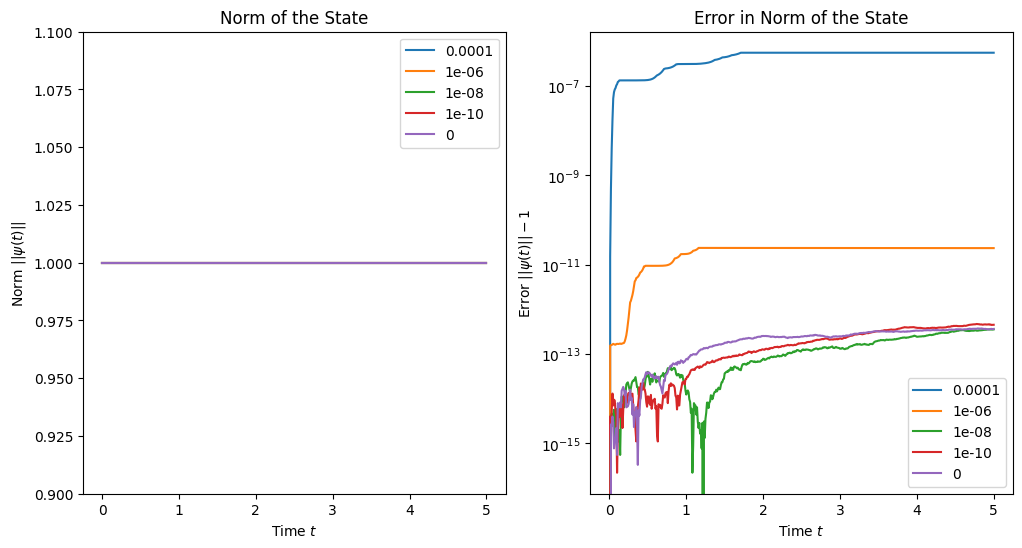

In [18]:
fig, ax = subplots(1, 2 , figsize=(12,6))
for i, bug in enumerate(binary_bugs):
    ax[0].plot(times, norms[i], label=f"{total_tols[i]}")
ax[0].set_ylim(0.9,1.1)
ax[0].set_title("Norm of the State")
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel("Norm $||\psi(t)||$")
ax[0].legend()

for i, bug in enumerate(binary_bugs):
    ax[1].semilogy(times, norm_errors[i], label=f"{total_tols[i]}")
ax[1].set_title("Error in Norm of the State")
ax[1].set_xlabel("Time $t$")
ax[1].set_ylabel("Error $||\psi(t)|| - 1$")
ax[1].legend()

show()

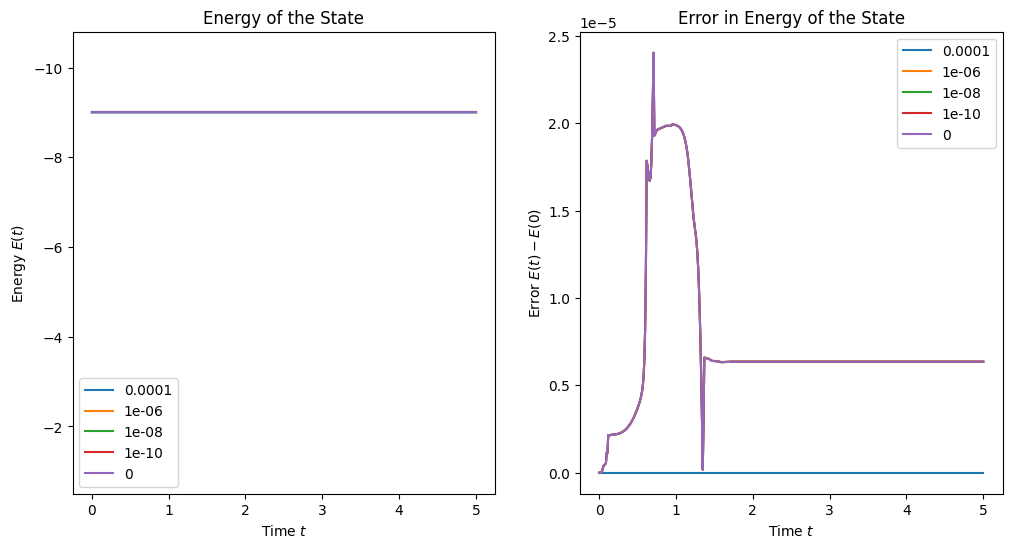

In [19]:
energies = [bug.operator_result("energy", realise=True) for bug in binary_bugs]
energy_errors = [npabs(energy - energies[0]) for energy in energies]

fig, ax = subplots(1, 2 , figsize=(12,6))
for i, bug in enumerate(binary_bugs):
    ax[0].plot(times, energies[i], label=f"{total_tols[i]}")
ax[0].set_ylim(-0.5, npmax(energies)*1.2)
ax[0].set_title("Energy of the State")
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel("Energy $E(t)$")
ax[0].legend()

for i, bug in enumerate(binary_bugs):
    ax[1].plot(times, energy_errors[i], label=f"{total_tols[i]}")
ax[1].set_title("Error in Energy of the State")
ax[1].set_xlabel("Time $t$")
ax[1].set_ylabel("Error $E(t) - E(0)$")
ax[1].legend()

show()

In [20]:
exact_local_magnetisation_results = [exact_evo.operator_result(identifier, realise=True) for identifier in site_ids]
exact_total_magnetisation_result = total_magnetisation(exact_local_magnetisation_results)
bug_total_magnetisation_results = []
bug_total_magn_erros = []
for bug in binary_bugs:
    bug_local_magnetisation_results = [bug.operator_result(identifier, realise=True) for identifier in site_ids]
    bug_total_magnetisation_results.append(total_magnetisation(bug_local_magnetisation_results))
    bug_total_magn_erros.append(npabs(bug_total_magnetisation_results[-1] - exact_total_magnetisation_result))

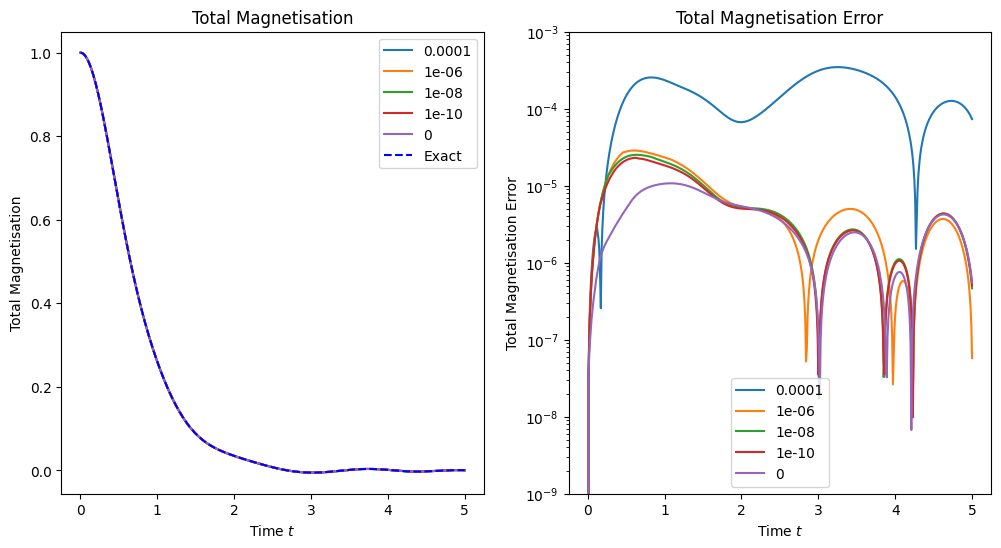

In [21]:
fig, ax = subplots(1, 2, figsize=(12, 6))
for i, bug in enumerate(binary_bugs):
    ax[0].plot(times, bug_total_magnetisation_results[i], label=f"{total_tols[i]}")
ax[0].plot(times, exact_total_magnetisation_result, label="Exact", color="b", linestyle="--")
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel("Total Magnetisation")
ax[0].legend()
ax[0].set_title("Total Magnetisation")

for i, bug in enumerate(binary_bugs):
    ax[1].semilogy(times, bug_total_magn_erros[i], label=f"{total_tols[i]}")
ax[1].set_ylim(1e-9, 1e-3)
ax[1].set_xlabel("Time $t$")
ax[1].set_ylabel("Total Magnetisation Error")
ax[1].set_title("Total Magnetisation Error")
ax[1].legend()

show()

In [22]:
for bug in binary_bugs:
    print(bug.state.bond_dims())

{('Root', 'Virtual_1_0'): 8, ('Virtual_1_0', 'Virtual_2_0'): 8, ('Virtual_1_0', 'Virtual_2_1'): 16, ('Root', 'Virtual_2_2'): 8, ('Virtual_2_0', 'Virtual_3_0'): 4, ('Virtual_2_1', 'Virtual_3_1'): 4, ('Virtual_2_1', 'Virtual_3_2'): 4, ('Virtual_2_2', 'Virtual_3_3'): 4, ('Virtual_2_0', 'Qubit_0'): 2, ('Virtual_3_0', 'Qubit_1'): 2, ('Virtual_3_0', 'Qubit_2'): 2, ('Virtual_3_1', 'Qubit_3'): 2, ('Virtual_3_1', 'Qubit_4'): 2, ('Virtual_3_2', 'Qubit_5'): 2, ('Virtual_3_2', 'Qubit_6'): 2, ('Virtual_3_3', 'Qubit_7'): 2, ('Virtual_3_3', 'Qubit_8'): 2, ('Virtual_2_2', 'Qubit_9'): 2}
{('Root', 'Virtual_1_0'): 8, ('Virtual_1_0', 'Virtual_2_0'): 8, ('Virtual_1_0', 'Virtual_2_1'): 16, ('Root', 'Virtual_2_2'): 8, ('Virtual_2_0', 'Virtual_3_0'): 4, ('Virtual_2_1', 'Virtual_3_1'): 4, ('Virtual_2_1', 'Virtual_3_2'): 4, ('Virtual_2_2', 'Virtual_3_3'): 4, ('Virtual_2_0', 'Qubit_0'): 2, ('Virtual_3_0', 'Qubit_1'): 2, ('Virtual_3_0', 'Qubit_2'): 2, ('Virtual_3_1', 'Qubit_3'): 2, ('Virtual_3_1', 'Qubit_4'): 2,